# IMPORTS

In [4]:
%%capture
import sys
import re
import tensorflow as tf
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
 
# Install EfficientNet
!pip install -U efficientnet
import efficientnet.tfkeras

# Install Scikitplot
! pip install -q scikit-plot
import scikitplot as skplt

# TPU / GPU DETECTION

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
 
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
 
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.33.201.58:8470


Running on TPU  grpc://10.33.201.58:8470


INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:

REPLICAS:  8


# DATA ACCESS
TPUs read data directly from Google Cloud Storage (GCS).

In [6]:
# GCS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_PATH"
GCS_PATH = 'gs://huynhdoo/prostate-cancer/mounting/'
!gsutil ls $GCS_PATH

gs://huynhdoo/prostate-cancer/mounting/128x16/
gs://huynhdoo/prostate-cancer/mounting/128x36/
gs://huynhdoo/prostate-cancer/mounting/256x36/
gs://huynhdoo/prostate-cancer/mounting/64x64/
gs://huynhdoo/prostate-cancer/mounting/tf-slide/


# CONFIGURATION 

In [7]:
# The dataset can be availabe in multiple image sizes.
PATCH_SIZE = [128, 36]
IMAGE_SIZE = [PATCH_SIZE[0]*PATCH_SIZE[1], PATCH_SIZE[0]*PATCH_SIZE[1]]
TARGET_SIZE = [528, 528]
#EfficientNetB0 - (224, 224, 3) / EfficientNetB2 - (260, 260, 3) / EfficientNetB4 - (380, 380, 3) / EfficientNetB6 - (528, 528, 3)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync # this is 8 on TPU v3-8, it is 1 on CPU and GPU
 
PANDA_DATASETS = { # available image sizes
    64: GCS_PATH + '64x64/tfrec-jpg-512x512/*.tfrec',
    #128: GCS_PATH + 'tf-slide/tfrec-jpeg-512x512/*.tfrec',
    #128: GCS_PATH + '128x16/tfrec-jpg-512x512/*.tfrec',
    128: GCS_PATH + '128x36/tfrec-jpg-768x768/*.tfrec',
    256: GCS_PATH + '256x36/tfrec-jpg-1536x1536/*.tfrec'
}
CLASSES = ['0', '1', '2', '3', '4', '5'] # do not change, maps to the labels in the data (folder names)
FRACTIONS = np.array([2892, 2666, 1343, 1242, 1249, 1224]).astype(np.float32)/10616
CLASSES_WEIGHTS = {0: 1.0, 
                   1: 1.0843881856540085, 
                   2: 2.153631284916201, 
                   3: 2.3269617706237424, 
                   4: 2.315315315315315, 
                   5: 2.362614913176711}
 
print('DATASETS:', PANDA_DATASETS[PATCH_SIZE[0]])
print('TFRECORDS:', len(tf.io.gfile.glob(PANDA_DATASETS[PATCH_SIZE[0]])))

DATASETS: gs://huynhdoo/prostate-cancer/mounting/128x36/tfrec-jpg-768x768/*.tfrec
TFRECORDS: 42


# VISUALIZATIONS UTILITIES

data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [8]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels
 
def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)  # one-hot to class number
    correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
 
def display_one_image(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_images_from_dataset(dataset, num):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        if i >= num:
            break;
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_image(image, title, subplot)
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()  
 
def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_image(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# DATASET

## Dataset utilities

In [9]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
 
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.string),
        "class_num": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
 
    # Standardize image
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]    
    #image = tf.image.per_image_standardization(image) # standardize image with 0 mean and 1 deviation
    image = tf.image.resize(image, size = TARGET_SIZE) # standardize image size
    
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [6])
    return image, one_hot_class
 
def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
 
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset
    
def balance_dataset(dataset):
    get_label = lambda image, one_hot_class: tf.argmax(one_hot_class)
 
    resample_ds = dataset.apply(
        tf.data.experimental.rejection_resample(
            get_label, 
            target_dist=[1/len(CLASSES)]*len(CLASSES), 
            initial_dist=FRACTIONS)
        )
    dataset = resample_ds.map(lambda extra_label, features_and_label: features_and_label)
    return dataset
 
def data_augment(image, one_hot_class):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    #image = tf.image.random_contrast(image, 0, 2)
    #image = tf.image.random_brightness(image, 0.2)
    return image, one_hot_class
 
def get_training_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = balance_dataset(dataset)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2048)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset
 
def get_validation_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

## Dataset loading

In [10]:
GCS_PATTERN = PANDA_DATASETS[PATCH_SIZE[0]]
FILENAMES = tf.io.gfile.glob(GCS_PATTERN)
TEST_SPLIT = 0.01
FOLDS = 10
 
REMAINING_FILENAMES, TEST_FILENAMES = train_test_split(FILENAMES, test_size=TEST_SPLIT, random_state=512)
TRAINING_FILENAMES = []
VALIDATION_FILENAMES = []
TRAIN_STEPS = []
 
kfold = KFold(FOLDS, shuffle = True, random_state = 512)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(REMAINING_FILENAMES)):
    TRAINING_FILENAMES.append(np.array(REMAINING_FILENAMES)[trn_ind])
    VALIDATION_FILENAMES.append(np.array(REMAINING_FILENAMES)[val_ind])
    TRAIN_STEPS.append(count_data_items(TRAINING_FILENAMES[fold]) // BATCH_SIZE)
 
training_dataset = []
validation_dataset = []
 
for fold in range(FOLDS):
    training_dataset.append(get_training_dataset(TRAINING_FILENAMES[fold]))
    validation_dataset.append(get_validation_dataset(VALIDATION_FILENAMES[fold]))
 
print("TOTAL IMAGES:", count_data_items(FILENAMES), "- FOLDS:", FOLDS)
print("TESTING IMAGES:", count_data_items(TEST_FILENAMES))
print("REMAINING IMAGES:", count_data_items(REMAINING_FILENAMES))
print("-"*30)
print("TRAINING IMAGES:", count_data_items(TRAINING_FILENAMES[0]), "- STEPS PER EPOCH:", TRAIN_STEPS[0])
print("VALIDATION IMAGES:", count_data_items(VALIDATION_FILENAMES[0]))
print("-"*30)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



TOTAL IMAGES: 21230 - FOLDS: 10
TESTING IMAGES: 512
REMAINING IMAGES: 20718
------------------------------
TRAINING IMAGES: 18158 - STEPS PER EPOCH: 141
VALIDATION IMAGES: 2560
------------------------------


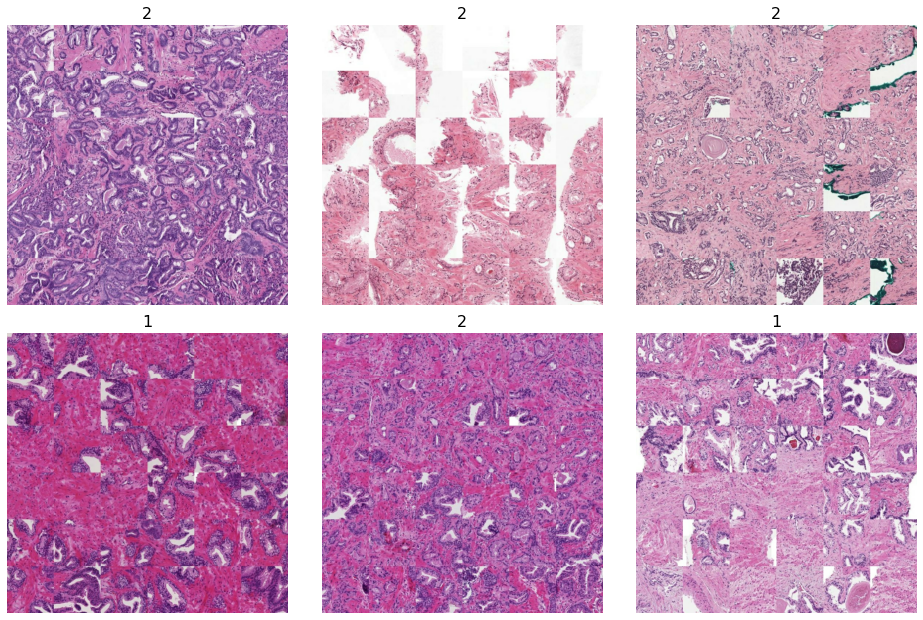

In [8]:
display_images_from_dataset(training_dataset[random.choice(range(FOLDS))], 6)

# GOOGLE CLOUD CREDENTIALS
You would need this if you were accessing private GCS buckets. Uncomment if you want to re-use this notebook to write data to you own private bucket.

In [13]:
if 'google.colab' in sys.modules:
   from google.colab import auth
   auth.authenticate_user()

# MODEL DEFINITION

## Kappa Loss function

In [11]:
import tensorflow.keras.backend as K
 
# Metrics
def quadratic_kappa_coefficient(y_true, y_pred):
    n_classes = K.cast(y_pred.shape[-1], "float32")
    weights = K.arange(0, n_classes, dtype="float32") / (n_classes - 1)
    weights = (weights - K.expand_dims(weights, -1)) ** 2
 
    hist_true = K.sum(y_true, axis=0)
    hist_pred = K.sum(y_pred, axis=0)
 
    E = K.expand_dims(hist_true, axis=-1) * hist_pred
    E = E / K.sum(E, keepdims=False)
 
    O = K.transpose(K.transpose(y_true) @ y_pred)  # confusion matrix
    O = O / K.sum(O)
 
    num = weights * O
    den = weights * E
 
    QWK = (1 - K.sum(num) / K.sum(den))
    return QWK
 
# Loss
def quadratic_kappa_loss(scale=6.0):
    def _quadratic_kappa_loss(y_true, y_pred):
        QWK = quadratic_kappa_coefficient(y_true, y_pred)
        loss = -K.log(K.sigmoid(scale * QWK))
        return loss
 
    return _quadratic_kappa_loss

## Model creation

In [12]:
def create_model(trainable=True):    
    #pretrained_model = efficientnet.tfkeras.EfficientNetB0(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
    #pretrained_model = efficientnet.tfkeras.EfficientNetB2(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
    #pretrained_model = efficientnet.tfkeras.EfficientNetB4(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model = efficientnet.tfkeras.EfficientNetB6(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
    
    pretrained_model.trainable = trainable

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(), # EfficientNet
        tf.keras.layers.Dropout(0.2), # EfficientNet
        #tf.keras.layers.Dense(128, activation='relu'), # EfficientNet
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        #loss = 'categorical_crossentropy',
        #metrics='categorical_accuracy'
        loss = quadratic_kappa_loss(scale=len(CLASSES)),
        metrics=[quadratic_kappa_coefficient]
    )
    return model

In [11]:
# Show model
model = create_model(False)
model.summary()
del model

165527552/165527152 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 17, 17, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 13830     
Total params: 40,973,966
Trainable params: 13,830
Non-trainable params: 40,960,136
_________________________________________________________________


# TRAINING

## Learning rate scheduler

In [15]:
# Learning rate scheduler for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.
def lrfn(epoch):
    LR_MAX = LR_START * 5 * strategy.num_replicas_in_sync
    LR_MIN = LR_START
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = 0.8

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
def print_lrfn(epochs):
    rng = [i for i in range(epochs)]
    y = [lrfn(x) for x in rng]
    plt.plot(rng, y)
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

Learning rate schedule: 3e-05 to 0.0012 to 3.55e-05


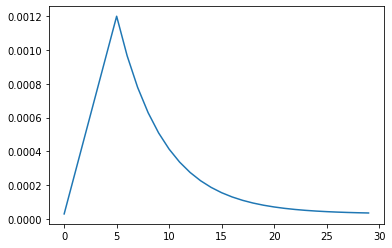

In [53]:
# Testing learning curve
LR_START = 3e-5
print_lrfn(50)

## Training function

In [16]:
def training(folds=1, weights=None, epochs=15):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    
    for fold in range(folds):
        print('Release TPU memory...')
        tf.tpu.experimental.initialize_tpu_system(tpu) # Release TPU memory
 
        print('Creating model {}/{}...'.format(fold+1, folds))
        with strategy.scope():
            model = create_model(trainable=True) # Create model on TPU
 
        if weights:
            print('Loading weights {}...'.format(weights))
            model.load_weights(weights)
 
        checkpoint_name = f'model_fold_{fold + 1}' + '.h5'
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, 
                                                            save_best_only = True, 
                                                            save_weights_only = True)
        
        print('Training model {}/{}...'.format(fold+1, folds))        
        history = model.fit(
            training_dataset[fold], 
            steps_per_epoch = TRAIN_STEPS[fold],
            epochs = epochs,
            class_weight=CLASSES_WEIGHTS,
            callbacks = [early_stopping, model_checkpoint, lr_callback],
            validation_data = validation_dataset[fold]
        )
        model_accuracy = history.history["val_quadratic_kappa_coefficient"][-5:]
        print("Model accuracy MEAN-5: ", np.mean(model_accuracy))
 
        print('Saving best model {}/{}'.format(fold+1, folds)) 
        model.load_weights(checkpoint_name)
        models.append(model)
        histories.append(history)
 
    return models, histories

## One step training

In [59]:
# One step training
LR_START = 3e-5
model, history = training(folds=1, weights=None, epochs=30)

INFO:tensorflow:Initializing the TPU system: grpc://10.33.201.58:8470
INFO:tensorflow:Clearing out eager caches


Release TPU memory...


INFO:tensorflow:Finished initializing TPU system.


Creating model 1/1...
Training model 1/1...

Epoch 00001: LearningRateScheduler reducing learning rate to 3e-05.
Epoch 1/30
141/141 [==============================] - 202s 1s/step - quadratic_kappa_coefficient: 0.3097 - loss: 0.4155 - val_quadratic_kappa_coefficient: 0.3296 - val_loss: 0.1548 - lr: 3.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000264.
Epoch 2/30
141/141 [==============================] - 184s 1s/step - quadratic_kappa_coefficient: 0.6038 - loss: 0.0744 - val_quadratic_kappa_coefficient: 0.6860 - val_loss: 0.0262 - lr: 2.6400e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000498.
Epoch 3/30
141/141 [==============================] - 184s 1s/step - quadratic_kappa_coefficient: 0.6821 - loss: 0.0423 - val_quadratic_kappa_coefficient: 0.7449 - val_loss: 0.0180 - lr: 4.9800e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007319999999999999.
Epoch 4/30
141/141 [==============================] - 176s 1s/st

In [64]:
# Save and export model
model_name = 'EfficientNetB6_model.h5'
model[0].save(model_name)
!gsutil cp $model_name gs://huynhdoo/prostate-cancer/model

Copying file://EfficientNetB6_model.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][469.5 MiB/469.5 MiB]                                                
Operation completed over 1 objects/469.5 MiB.                                    


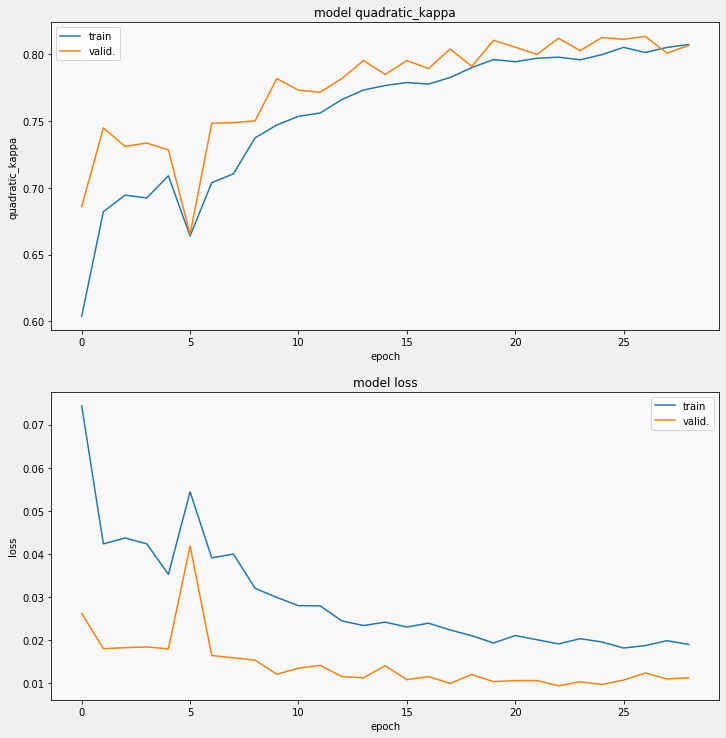

In [65]:
# Displaying curves
display_training_curves(history[0].history['quadratic_kappa_coefficient'][1:], history[0].history['val_quadratic_kappa_coefficient'][1:], 'quadratic_kappa', 211)
display_training_curves(history[0].history['loss'][1:], history[0].history['val_loss'][1:], 'loss', 212)

## Cross validation training

In [ ]:
# Cross validation training
LR_START = 3e-8
models, histories = training(folds=2, weights='model_fold_1.h5', epochs=1)

INFO:tensorflow:Initializing the TPU system: grpc://10.33.201.58:8470
INFO:tensorflow:Clearing out eager caches


Release TPU memory...


INFO:tensorflow:Finished initializing TPU system.


Creating model 1/10...
Loading weights model_fold_1.h5...
Training model 1/10...

Epoch 00001: LearningRateScheduler reducing learning rate to 3e-08.
141/141 [==============================] - 200s 1s/step - quadratic_kappa_coefficient: 0.8012 - loss: 0.0200 - val_quadratic_kappa_coefficient: 0.8089 - val_loss: 0.0099 - lr: 3.0000e-08
Model accuracy MEAN-5:  0.808940589427948
Saving best model 1/10


INFO:tensorflow:Initializing the TPU system: grpc://10.33.201.58:8470
INFO:tensorflow:Clearing out eager caches


Release TPU memory...


INFO:tensorflow:Finished initializing TPU system.


Creating model 2/10...
Loading weights model_fold_1.h5...
Training model 2/10...

Epoch 00001: LearningRateScheduler reducing learning rate to 3e-08.
145/145 [==============================] - 205s 1s/step - quadratic_kappa_coefficient: 0.7967 - loss: 0.0213 - val_quadratic_kappa_coefficient: 0.8526 - val_loss: 0.0071 - lr: 3.0000e-08
Model accuracy MEAN-5:  0.8526297211647034
Saving best model 2/10


In [ ]:
# Displaying curves
for fold in range(2):
    history = histories[fold]
    print('Model ', fold+1)
    display_training_curves(history.history['quadratic_kappa_coefficient'][1:], history.history['val_quadratic_kappa_coefficient'][1:], 'quadratic_kappa', 211)
    display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [1]:
!gsutil cp model_fold_1.h5 gs://huynhdoo/prostate-cancer/model/EfficientNetB6_weights_1.h5
!gsutil cp model_fold_2.h5 gs://huynhdoo/prostate-cancer/model/EfficientNetB6_weights_2.h5

Copying file://model_fold_1.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][157.0 MiB/157.0 MiB]                                                
Operation completed over 1 objects/157.0 MiB.                                    
Copying file://model_fold_2.h5 [Content-Type=application/octet-stream]...
==> NOTE: You

In [3]:
model_name = 'EfficientNetB6_model.h5'
reload_model = tf.keras.models.load_model(model_name, compile=False)

NameError: ignored

## Model import/export
Uncomment if needed to save/load previous trained model

In [14]:
def load_model_from_weights(weights):
    with strategy.scope():
        model = create_model(True)
        model.load_weights(weigths)
    return model

def save_model(model, name):
    model.save(name)

In [17]:
#model_weights = 'EfficientNetB6_weights.h5'

# Export model weights to GCS
# !gsutil cp $model_weights gs://huynhdoo/prostate-cancer/model/

# Import model weights from GCS
#!gsutil cp gs://huynhdoo/prostate-cancer/model/$model_weights .
#model = load_model_from_weights(model_weights)

model_name = 'EfficientNetB6.h5'
# Export full model to GCS
#model.save(model_name)
#!gsutil cp $model_name gs://huynhdoo/prostate-cancer/model/

reload_model = tf.keras.models.load_model(model_name, compile=False)

# PREDICTIONS

## Test accurracy

In [18]:
def predict(models, folds, dataset):
    # get the mean probability of the folds models
    probabilities = np.average([models[i].predict(dataset) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    return predictions

test_dataset = load_dataset(TEST_FILENAMES, ordered=True)

In [19]:
from sklearn.metrics import cohen_kappa_score

# Make predictions on one step training
y_preds = predict([reload_model], 1, test_dataset.batch(BATCH_SIZE))
y_truth = [np.argmax(label.numpy()) for image, label in test_dataset]
#print(list(y_preds)[:10])
# print(y_truth[:10])
print('Mean accuracy:', round(np.count_nonzero(y_preds == np.array(y_truth))/len(y_truth),2))
print('Kappa score:', cohen_kappa_score(y_truth, y_preds, weights = 'quadratic'))

Mean accuracy: 0.5
Kappa score: 0.816713720755861


## Display predictions

In [51]:
# a couple of images to test predictions too
some_slides, some_labels = dataset_to_numpy_util(test_dataset.batch(BATCH_SIZE), 160)

# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(160)
some_slides, some_labels = (some_slides[permutation], some_labels[permutation])
predictions = reload_model.predict(some_slides, batch_size=BATCH_SIZE)

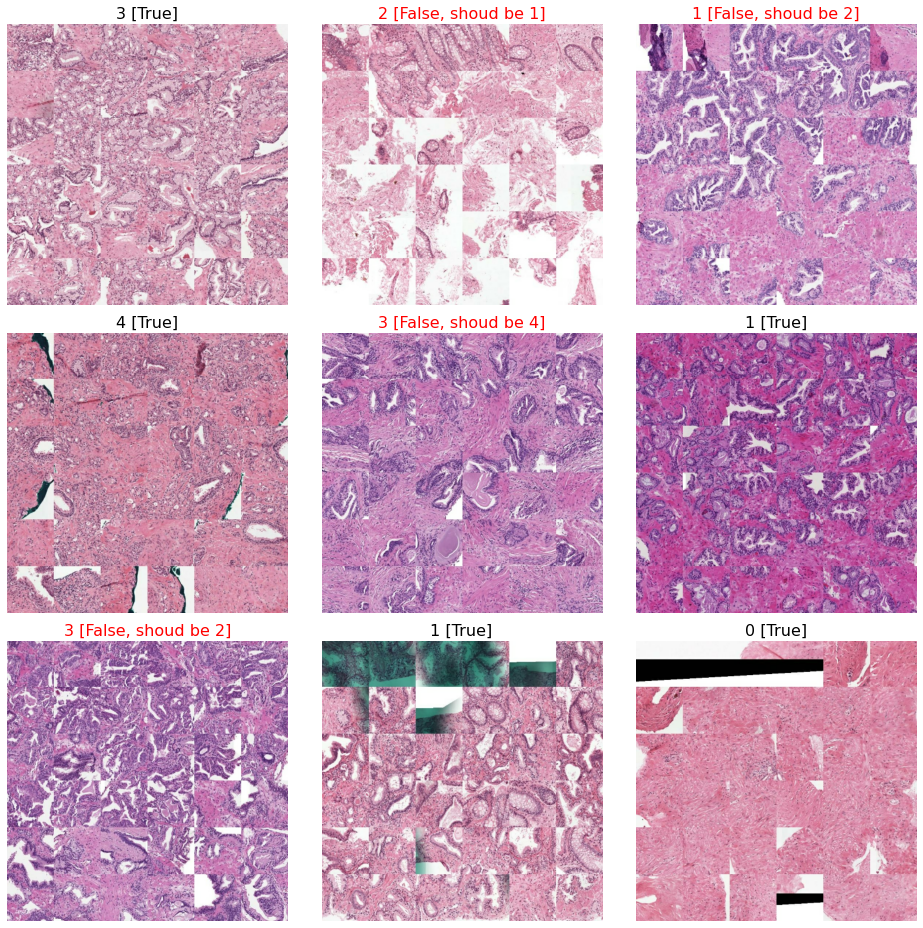

In [53]:
display_9_images_with_predictions(some_slides, predictions, some_labels)

## Confusion matrix

In [23]:
conf_matrix = confusion_matrix(y_truth, y_preds)
print('Confusion Matrix')
print(conf_matrix)

Confusion Matrix
[[97 31 13  1  1  0]
 [29 72 30  4  2  0]
 [ 0 14 24 21  3  1]
 [ 0  2  5 17 28  9]
 [ 0  6  7  6 21 20]
 [ 1  1  0  8 14 24]]


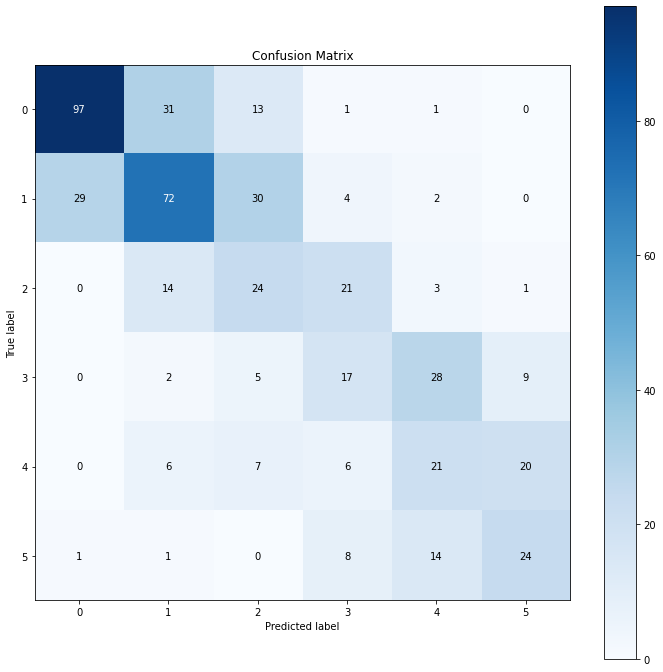

In [22]:
skplt.metrics.plot_confusion_matrix(y_truth, y_preds, figsize=(12,12))

In [24]:
print('Classification Report')
print(classification_report(y_truth, y_preds, target_names=CLASSES))

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       143
           1       0.57      0.53      0.55       137
           2       0.30      0.38      0.34        63
           3       0.30      0.28      0.29        61
           4       0.30      0.35      0.33        60
           5       0.44      0.50      0.47        48

    accuracy                           0.50       512
   macro avg       0.45      0.45      0.45       512
weighted avg       0.52      0.50      0.51       512



# LICENSE



---

ORIGINAL<br>
author: Martin Gorner<br>
twitter: @martin_gorner

FORK<br>
author: Do Huynh<br>
git: huynhdoo

---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
